In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
from tqdm import tqdm
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns

warnings.filterwarnings("ignore")


In [2]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/


Mounted at /content/drive/
/content/drive/My Drive


In [3]:
data_transforms = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.4149, 0.4694, 0.4844],
                          std=[0.2512, 0.2512, 0.2512]),
])

batch_size = 128
num_workers = 4


train_dir = '/content/drive/My Drive/mydataset1/Datasets/Tiny/train'
test_dir = '/content/drive/My Drive/mydataset1/Datasets/Tiny/test'
val_dir = '/content/drive/My Drive/mydataset1/Datasets/Tiny/validation'


train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [4]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

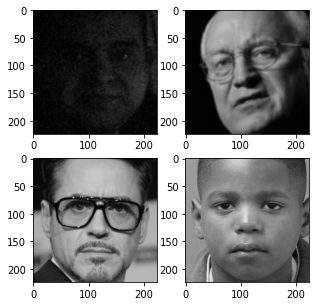

In [5]:
plot_data_loader(train_loader, (2, 2))

In [6]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 13


In [7]:
torch.cuda.empty_cache()

In [8]:
train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Train Size: 9620
Test Size: 2990
Validation Size: 2470


In [9]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Linear(num_ftrs, len(train_dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Device: {}".format(device))

num_epochs = 25

Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip


Device: cuda:0


In [10]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [11]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    return epoch_loss, epoch_acc

In [12]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = test_model(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            pbar.update(1)


Epoch 1/25 | Train Loss: 2.1124 | Train Acc: 0.1560 | Val Loss: 3.5431 | Val Acc: 0.0939


Epoch 1/25: 100%|██████████| 76/76 [00:39<00:00,  1.94batch/s]


Epoch 2/25 | Train Loss: 2.0354 | Train Acc: 0.1814 | Val Loss: 1.9437 | Val Acc: 0.1895


Epoch 2/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 3/25 | Train Loss: 1.9704 | Train Acc: 0.1913 | Val Loss: 1.8914 | Val Acc: 0.2097


Epoch 3/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 4/25 | Train Loss: 1.9001 | Train Acc: 0.2278 | Val Loss: 1.8306 | Val Acc: 0.2514


Epoch 4/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 5/25 | Train Loss: 1.8754 | Train Acc: 0.2431 | Val Loss: 1.8341 | Val Acc: 0.2595


Epoch 5/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 6/25 | Train Loss: 1.9156 | Train Acc: 0.2249 | Val Loss: 1.7904 | Val Acc: 0.2721


Epoch 6/25: 100%|██████████| 76/76 [00:39<00:00,  1.95batch/s]


Epoch 7/25 | Train Loss: 1.7341 | Train Acc: 0.2941 | Val Loss: 1.7472 | Val Acc: 0.3053


Epoch 7/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 8/25 | Train Loss: 1.6279 | Train Acc: 0.3467 | Val Loss: 1.5984 | Val Acc: 0.3623


Epoch 8/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 9/25 | Train Loss: 1.5520 | Train Acc: 0.3793 | Val Loss: 1.4839 | Val Acc: 0.4113


Epoch 9/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 10/25 | Train Loss: 1.4134 | Train Acc: 0.4346 | Val Loss: 1.4476 | Val Acc: 0.4401


Epoch 10/25: 100%|██████████| 76/76 [00:39<00:00,  1.94batch/s]


Epoch 11/25 | Train Loss: 1.3187 | Train Acc: 0.4727 | Val Loss: 1.4067 | Val Acc: 0.4636


Epoch 11/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 12/25 | Train Loss: 1.2010 | Train Acc: 0.5228 | Val Loss: 1.3564 | Val Acc: 0.5000


Epoch 12/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 13/25 | Train Loss: 1.0748 | Train Acc: 0.5766 | Val Loss: 1.2407 | Val Acc: 0.5510


Epoch 13/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 14/25 | Train Loss: 0.9549 | Train Acc: 0.6228 | Val Loss: 1.3029 | Val Acc: 0.5551


Epoch 14/25: 100%|██████████| 76/76 [00:38<00:00,  1.95batch/s]


Epoch 15/25 | Train Loss: 0.8374 | Train Acc: 0.6699 | Val Loss: 1.1532 | Val Acc: 0.6146


Epoch 15/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 16/25 | Train Loss: 0.6828 | Train Acc: 0.7393 | Val Loss: 1.2036 | Val Acc: 0.6263


Epoch 16/25: 100%|██████████| 76/76 [00:39<00:00,  1.94batch/s]


Epoch 17/25 | Train Loss: 0.7182 | Train Acc: 0.7277 | Val Loss: 1.2235 | Val Acc: 0.6413


Epoch 17/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 18/25 | Train Loss: 0.4865 | Train Acc: 0.8184 | Val Loss: 1.1079 | Val Acc: 0.7081


Epoch 18/25: 100%|██████████| 76/76 [00:39<00:00,  1.94batch/s]


Epoch 19/25 | Train Loss: 0.3227 | Train Acc: 0.8894 | Val Loss: 1.1577 | Val Acc: 0.7336


Epoch 19/25: 100%|██████████| 76/76 [00:38<00:00,  1.97batch/s]


Epoch 20/25 | Train Loss: 0.2449 | Train Acc: 0.9169 | Val Loss: 1.1632 | Val Acc: 0.7389


Epoch 20/25: 100%|██████████| 76/76 [00:39<00:00,  1.95batch/s]


Epoch 21/25 | Train Loss: 0.2438 | Train Acc: 0.9174 | Val Loss: 1.2140 | Val Acc: 0.7449


Epoch 21/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 22/25 | Train Loss: 0.1692 | Train Acc: 0.9458 | Val Loss: 1.2874 | Val Acc: 0.7490


Epoch 22/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 23/25 | Train Loss: 0.1318 | Train Acc: 0.9607 | Val Loss: 1.2780 | Val Acc: 0.7615


Epoch 23/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


Epoch 24/25 | Train Loss: 0.0900 | Train Acc: 0.9723 | Val Loss: 1.3072 | Val Acc: 0.7603


Epoch 24/25: 100%|██████████| 76/76 [00:39<00:00,  1.95batch/s]


Epoch 25/25 | Train Loss: 0.1202 | Train Acc: 0.9599 | Val Loss: 1.3105 | Val Acc: 0.7632


Epoch 25/25: 100%|██████████| 76/76 [00:38<00:00,  1.96batch/s]


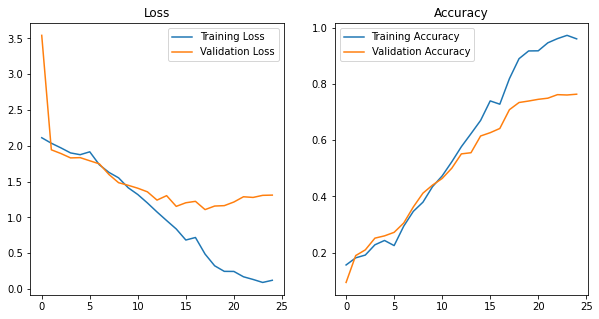

In [15]:
train_accs=torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()

Test Accuracy of the model on the 2990 test images: 68.92976588628763 %


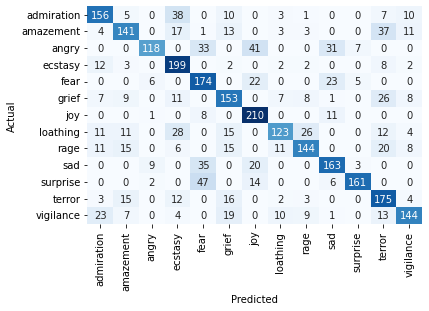

In [16]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to("cuda:0"), data[1].to("cuda:0")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


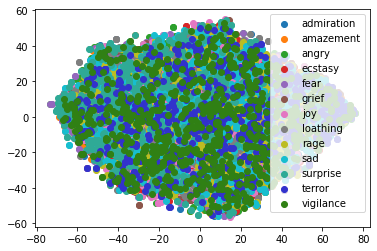

In [17]:
label_names = ['admiration', 'amazement', 'angry','ecstasy','fear','grief','joy','loathing','rage','sad','surprise','terror','vigilance']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#2FAA96','#3232CC','#308014']

mobilenetv2 = models.mobilenet_v2(pretrained=False)
mobilenetv2 = torch.nn.Sequential(*list(mobilenetv2.children())[:-1])
mobilenetv2.eval()


features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        outputs = mobilenetv2(images)
        features.append(outputs.view(outputs.size(0), -1).numpy())
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()

